# XID+ Example Run Script

(This is based on a Jupyter notebook, available in the [XID+ package](https://github.com/H-E-L-P/XID_plus/tree/master/docs/notebooks/examples/) and can be interactively run and edited)

XID+ is a probababilistic deblender for confusion dominated maps. It is designed to:

1. Use a MCMC based approach to get FULL posterior probability distribution on flux
2. Provide a natural framework to introduce additional prior information
3. Allows more representative estimation of source flux density uncertainties
4. Provides a platform for doing science with the maps (e.g XID+ Hierarchical stacking, Luminosity function from the map etc)

Cross-identification tends to be done with catalogues, then science with the matched catalogues.

XID+ takes a different philosophy. Catalogues are a form of data compression. OK in some cases, not so much in others, i.e. confused images: catalogue compression loses correlation information. Ideally, science should be done without compression.

XID+ provides a framework to cross identify galaxies we know about in different maps, with the idea that it can be extended to do science with the maps!!


Philosophy: 

- build a probabilistic generative model for the SPIRE maps
- Infer model on SPIRE maps

Bayes Theorem

$p(\mathbf{f}|\mathbf{d}) \propto p(\mathbf{d}|\mathbf{f}) \times p(\mathbf{f})$

In order to carry out Bayesian inference, we need a model to carry out inference on.

For the SPIRE maps, our model is quite simple, with likelihood defined as:
    $L = p(\mathbf{d}|\mathbf{f}) \propto |\mathbf{N_d}|^{-1/2} \exp\big\{ -\frac{1}{2}(\mathbf{d}-\mathbf{Af})^T\mathbf{N_d}^{-1}(\mathbf{d}-\mathbf{Af})\big\}$

where:
    $\mathbf{N_{d,ii}} =\sigma_{inst.,ii}^2+\sigma_{conf.}^2$

Simplest model for XID+ assumes following:

* All sources are known and have positive flux (fi)
* A global background (B) contributes to all pixels 
* PRF is fixed and known
* Confusion noise is constant and not correlated across pixels
----
Because we are getting the joint probability distribution, our model is generative i.e. given parameters, we generate data and vica-versa
    
Compared to discriminative model (i.e. neural network), which only obtains conditional probability distribution i.e. Neural network, give inputs, get output. Can't go other way'

Generative model is full probabilistic model. Allows more complex relationships between observed and target variables


###  XID+ SPIRE
XID+ applied to GALFORM simulation of COSMOS field

* SAM simulation (with dust) ran through SMAP pipeline_ similar depth and size as COSMOS
* Use galaxies with an observed 100 micron flux of gt. $50\mathbf{\mu Jy}$. Gives 64823 sources
* Uninformative prior: uniform $0 - 10{^3} \mathbf{mJy}$


Import required modules

In [1]:
from astropy.io import ascii, fits
import pylab as plt
%matplotlib inline
from astropy import wcs


import numpy as np
import xidplus
from xidplus import moc_routines
import pickle
import seaborn as sns
import aplpy
import pandas as pd


/Users/pdh21/anaconda3/envs/xidplus/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


Set image and catalogue filenames

In [2]:
xidplus.__path__[0]

'/Users/pdh21/Google_Drive/WORK/XID_plus/xidplus'

In [3]:
#Folder containing maps
imfolder=xidplus.__path__[0]+'/../test_files/'

pswfits=imfolder+'cosmos_itermap_lacey_07012015_simulated_observation_w_noise_PSW_hipe.fits.gz'#SPIRE 250 map
pmwfits=imfolder+'cosmos_itermap_lacey_07012015_simulated_observation_w_noise_PMW_hipe.fits.gz'#SPIRE 350 map
plwfits=imfolder+'cosmos_itermap_lacey_07012015_simulated_observation_w_noise_PLW_hipe.fits.gz'#SPIRE 500 map


#Folder containing prior input catalogue
catfolder=xidplus.__path__[0]+'/../test_files/'
#prior catalogue
prior_cat='lacey_07012015_MillGas.ALLVOLS_cat_PSW_COSMOS_test.fits'


#output folder
output_folder='./'

Load in images, noise maps, header info and WCS information

In [4]:
#-----250-------------
hdulist = fits.open(pswfits)
im250phdu=hdulist[0].header
im250hdu=hdulist[1].header

im250=hdulist[1].data*1.0E3 #convert to mJy
nim250=hdulist[2].data*1.0E3 #convert to mJy
w_250 = wcs.WCS(hdulist[1].header)
pixsize250=3600.0*w_250.wcs.cd[1,1] #pixel size (in arcseconds)
hdulist.close()
#-----350-------------
hdulist = fits.open(pmwfits)
im350phdu=hdulist[0].header
im350hdu=hdulist[1].header

im350=hdulist[1].data*1.0E3 #convert to mJy
nim350=hdulist[2].data*1.0E3 #convert to mJy
w_350 = wcs.WCS(hdulist[1].header)
pixsize350=3600.0*w_350.wcs.cd[1,1] #pixel size (in arcseconds)
hdulist.close()
#-----500-------------
hdulist = fits.open(plwfits)
im500phdu=hdulist[0].header
im500hdu=hdulist[1].header 
im500=hdulist[1].data*1.0E3 #convert to mJy
nim500=hdulist[2].data*1.0E3 #convert to mJy
w_500 = wcs.WCS(hdulist[1].header)
pixsize500=3600.0*w_500.wcs.cd[1,1] #pixel size (in arcseconds)
hdulist.close()

Load in catalogue you want to fit (and make any cuts)

In [5]:
hdulist = fits.open(catfolder+prior_cat)
fcat=hdulist[1].data
hdulist.close()
inra=fcat['RA']
indec=fcat['DEC']
# select only sources with 100micron flux greater than 50 microJy
sgood=fcat['S100']>0.050
inra=inra[sgood]
indec=indec[sgood]
inz=fcat['Z_OBS'][sgood]

XID+ uses Multi Order Coverage (MOC) maps for cutting down maps and catalogues so they cover the same area. It can also take in MOCs as selection functions to carry out additional cuts. Lets use the python module [pymoc](http://pymoc.readthedocs.io/en/latest/) to create a MOC, centered on a specific position we are interested in. We will use a HEALPix order of 15 (the resolution: higher order means higher resolution), have a radius of 100 arcseconds centered around an R.A. of 150.74 degrees and Declination of 2.03 degrees.

In [6]:
from astropy.coordinates import SkyCoord
from astropy import units as u
c = SkyCoord(ra=[150.74]*u.degree, dec=[2.03]*u.degree)  
import pymoc
moc=pymoc.util.catalog.catalog_to_moc(c,100,15)

XID+ is built around two python classes. A prior and posterior class. There should be a prior class for each map being fitted. It is initiated with a map, noise map, primary header and map header and can be set with a MOC. It also requires an input prior catalogue and point spread function.


In [7]:
#---prior250--------
prior250=xidplus.prior(im250,nim250,im250phdu,im250hdu, moc=moc)#Initialise with map, uncertianty map, wcs info and primary header
prior250.prior_cat(inra,indec,prior_cat)#Set input catalogue
prior250.prior_bkg(-5.0,5)#Set prior on background (assumes Gaussian pdf with mu and sigma)
#---prior350--------
prior350=xidplus.prior(im350,nim350,im350phdu,im350hdu, moc=moc)
prior350.prior_cat(inra,indec,prior_cat)
prior350.prior_bkg(-5.0,5)

#---prior500--------
prior500=xidplus.prior(im500,nim500,im500phdu,im500hdu, moc=moc)
prior500.prior_cat(inra,indec,prior_cat)
prior500.prior_bkg(-5.0,5)

Set PRF. For SPIRE, the PRF can be assumed to be Gaussian with a FWHM of 18.15, 25.15, 36.3 '' for 250, 350 and 500 $\mathrm{\mu m}$ respectively. Lets use the astropy module to construct a Gaussian PRF and assign it to the three XID+ prior classes.

In [8]:
#pixsize array (size of pixels in arcseconds)
pixsize=np.array([pixsize250,pixsize350,pixsize500])
#point response function for the three bands
prfsize=np.array([18.15,25.15,36.3])
#use Gaussian2DKernel to create prf (requires stddev rather than fwhm hence pfwhm/2.355)
from astropy.convolution import Gaussian2DKernel

##---------fit using Gaussian beam-----------------------
prf250=Gaussian2DKernel(prfsize[0]/2.355,x_size=101,y_size=101)
prf250.normalize(mode='peak')
prf350=Gaussian2DKernel(prfsize[1]/2.355,x_size=101,y_size=101)
prf350.normalize(mode='peak')
prf500=Gaussian2DKernel(prfsize[2]/2.355,x_size=101,y_size=101)
prf500.normalize(mode='peak')

pind250=np.arange(0,101,1)*1.0/pixsize[0] #get 250 scale in terms of pixel scale of map
pind350=np.arange(0,101,1)*1.0/pixsize[1] #get 350 scale in terms of pixel scale of map
pind500=np.arange(0,101,1)*1.0/pixsize[2] #get 500 scale in terms of pixel scale of map

prior250.set_prf(prf250.array,pind250,pind250)#requires PRF as 2d grid, and x and y bins for grid (in pixel scale)
prior350.set_prf(prf350.array,pind350,pind350)
prior500.set_prf(prf500.array,pind500,pind500)

In [9]:
print('fitting '+ str(prior250.nsrc)+' sources \n')
print('using ' +  str(prior250.snpix)+', '+ str(prior250.snpix)+' and '+ str(prior500.snpix)+' pixels')


fitting 51 sources 

using 870, 870 and 219 pixels


Before fitting, the prior classes need to take the PRF and calculate how much each source contributes to each pixel. This process provides what we call a pointing matrix. Lets calculate the pointing matrix for each prior class

In [10]:
prior250.get_pointing_matrix()
prior350.get_pointing_matrix()
prior500.get_pointing_matrix()


Default prior on flux is a uniform distribution, with a minimum and maximum of 0.00 and 1000.0 $\mathrm{mJy}$ respectively for each source. running the function upper_lim _map resets the upper limit to the maximum flux value (plus a 5 sigma Background value) found in the map in which the source makes a contribution to.

In [11]:
prior250.upper_lim_map()
prior350.upper_lim_map()
prior500.upper_lim_map()

## Set physical params

In [12]:
np.full(prior250.nsrc,0.5)

array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5])

In [13]:
z_mu=inz[prior250.ID-1]
z_sig=np.full(prior250.nsrc,0.5)
lir_mu=np.full(prior250.nsrc,10)
lir_sig=np.full(prior250.nsrc,1)
t_mu=np.full(prior250.nsrc,40)
t_sig=np.full(prior250.nsrc,10)

In [120]:
params_mu=np.vstack((lir_mu,z_mu,t_mu)).T
params_sig=np.vstack((lir_sig,z_sig,t_sig)).T
params_names=['L_ir','z','Temp']
emulator_path='../../../../tests/GB_emulator_20210106.pkl'

In [121]:
class hier_prior(object):
    def __init__(self,ID,params_mu,params_sig,params_names,emulator_path):
        """Initiate SED prior class
        
        :param params_mu array with mean values of parameters
        :param params_sig array with sigma values of parameters
        :param params_names list of names of params
        :param emulator_path path to saved emulator file"""
        
        from astropy.table import Table, join
        from xidplus.numpyro_fit.misc import load_emulator
        mu_table=Table(params_mu,names=[i+'_mu' for i in params_names])
        sig_table=Table(params_sig,names=[i+'_sig' for i in params_names])
        
        mu_table.add_column(ID, name='ID')
        sig_table.add_column(ID, name='ID')
        
        self.prior_table=join(mu_table,sig_table,keys='ID')
        
        self.emulator=load_emulator(emulator_path)
        self.params_mu=self.emulator['transform_parameters'](params_mu.T)
        self.params_sig=self.emulator['transform_parameters'](params_mu.T+params_sig.T)-self.params_mu
        
        

In [122]:
phys_prior=hier_prior(prior250.ID,params_mu,params_sig,params_names,emulator_path)

## Generate Prior Predictive distribution

In [85]:
from numpyro.infer import Predictive
from jax import random, vmap
from xidplus.numpyro_fit import SED_prior

rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

In [86]:
## FOr numpyro to sample from the prior, the data needs to be set to None
priors=[prior250,prior350,prior500]
import copy
#make a deepcopy of the priors
priors_prior_pred=copy.deepcopy(priors)
#set data to None
for i in range(0,3):
    priors_prior_pred[i].sim=None


In [87]:
%%time 
#sample from the prior using numpyro's Predictive function
prior_predictive=Predictive(SED_prior.spire_model,posterior_samples = {}, num_samples = 50,)
prior_pred=prior_predictive(random.PRNGKey(0),priors_prior_pred,phys_prior)

CPU times: user 3.95 s, sys: 138 ms, total: 4.09 s
Wall time: 4.92 s


In [88]:
#Create a list of the model map arrays
mod_map_array=[prior_pred['obs_psw'].T,prior_pred['obs_pmw'].T,prior_pred['obs_plw'].T]

In [89]:
#feed the model map arrays the animation function
xidplus.plots.make_map_animation(priors,mod_map_array,50)

## Fit the simulated observations
To check whether `numpyro` can fit accurately, we will fit some of the prior predictive samples

You can fit with the [numpyro](https://github.com/pyro-ppl/numpyro) backend.

In [134]:
num_samp=10
posteriors=[]
for s in range(0,num_samp):
    print(s)
    #make a deepcopy of the priors
    priors_prior_pred_samp=copy.deepcopy(priors)
    #set data to sample data
    for i in range(0,3):
        priors_prior_pred_samp[i].sim=mod_map_array[i][:,s]
    fit_numpyro=SED_prior.all_bands(priors_prior_pred_samp,phys_prior)
    posteriors.append(xidplus.posterior_numpyro_sed(fit_numpyro,priors_prior_pred_samp,phys_prior))


0
Number of divergences: 0
1
Number of divergences: 0
2
Number of divergences: 0
3
Number of divergences: 0
4
Number of divergences: 0
5
Number of divergences: 0
6
Number of divergences: 0
7
Number of divergences: 0
8
Number of divergences: 0
9
Number of divergences: 0


In [135]:
for s in range(0,num_samp):
    print(s)
    #make a deepcopy of the priors
    priors_prior_pred_samp=copy.deepcopy(priors)
    #set data to sample data
    for i in range(0,3):
        priors_prior_pred_samp[i].sim=mod_map_array[i][:,s]
    xidplus.save(priors_prior_pred_samp,posteriors[i],'Prior_pred_fits_{}.pkl'.format(i))

0
1
2
3
4
5
6
7
8
9


### Evaluate Prior-Posterior consistency
We have fitted one sample. To be confident our chosen fitting algorithm works for all possible values (i.e. within Prior) we should fit many samples

To check the model and our inference technique (i.e. the algorithm used to fit the data) is perfoming appropriately, you can carry out simulated-based calibration. This involved fitting each prior sample as if it were data. The posterior distributions on the fits should look like the prior. This approach checks this is correct. If everything is working, the plots below for each parameter should be uniform.

For details, see Talts et al. 2018 and Michael Betancourt's case study

In [144]:
phys_samp_prior_pred=inverse_transform_parameters(prior_pred['params'])
param_cal=np.empty((len(posteriors),phys_samp_prior_pred.shape[1],phys_samp_prior_pred.shape[2]))
for i in range(0,len(posteriors)):
    phys_samp=inverse_transform_parameters(posteriors[i].samples['params'])
    for o in range(0,phys_samp_prior_pred.shape[1]):
        for p in range(0,3):
            param_cal[i,o,p]=np.sum(phys_samp[:,o,p]<phys_samp[i,o,p])



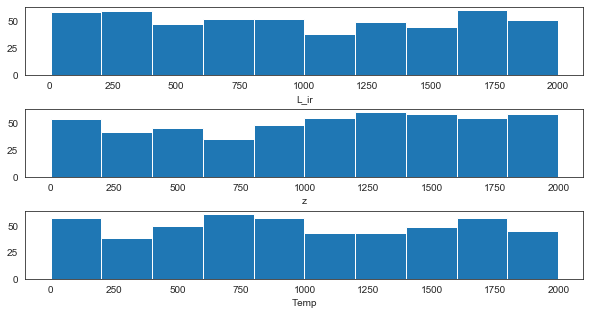

In [146]:
fig,axes=plt.subplots(3,1,figsize=(10,5))
names=[i.split('_mu')[0] for i in phys_prior.prior_table.colnames[0:3]]

for i in range(0,3):
    axes[i].hist(param_cal[:,:,i].flatten())
    axes[i].set_xlabel(names[i])
    
plt.subplots_adjust(hspace=0.5,wspace=0.5)

## Analyse Posterior Behaviours.
To visually check whether our model is being fit correctly, we can look at the replicated data coming from the fitted model and compare to the data it is fit to. For `xidplus` the data are the original maps. The best way to visualise this is to create an animation of the replicated maps, where the each frame is a sample from the posterior. The variation in pixel intensity across the animation illustrated the uncertianty in the model.

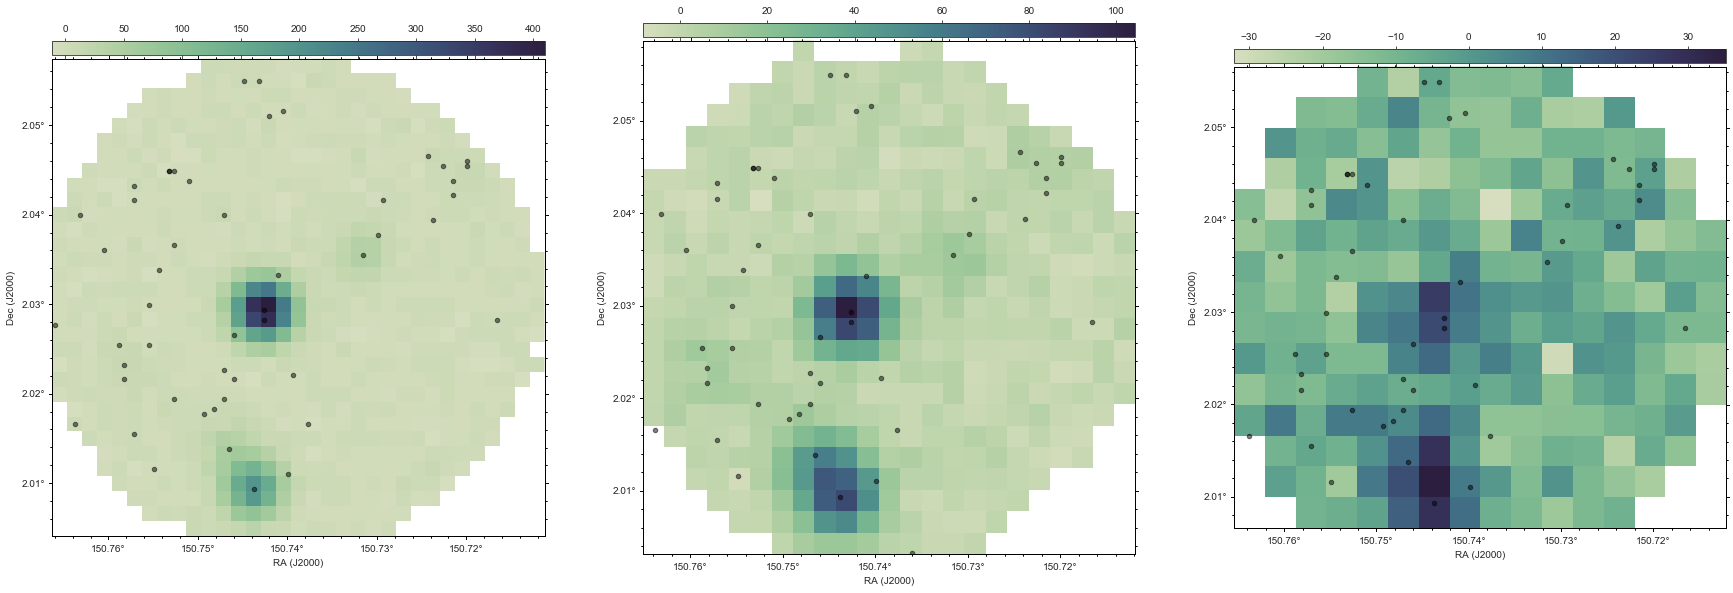

In [148]:
figs,fig=xidplus.plot_map(priors_prior_pred_samp)

In [149]:
priors_prior_pred_samp_p=copy.deepcopy(priors)
#set data to sample data
for i in range(0,3):
    priors_prior_pred_samp_p[i].sim=None
#sample from the prior using numpyro's Predictive function
prior_predictive_p=Predictive(SED_prior.spire_model,posterior_samples = fit_numpyro.get_samples(), num_samples = 50,)
prior_pred_p=prior_predictive_p(random.PRNGKey(0),priors_prior_pred_samp_p,phys_prior)
#Create a list of the model map arrays
mod_map_array=[prior_pred_p['obs_psw'].T,prior_pred_p['obs_pmw'].T,prior_pred_p['obs_plw'].T]
#feed the model map arrays the animation function
xidplus.plots.make_map_animation(priors_prior_pred_samp,mod_map_array,50)

In [101]:
def inverse_transform_parameters(param):
    """ function works with posterior samples"""
    LIR_sd=(15.0-8)/jnp.sqrt(12.0)
    LIR_mean=0.5*(15+8.0)
    
    red_sd=(6-0.01)/jnp.sqrt(12.0)
    red_mean=0.5*(0.01+6)
    
    temp_sd=(70-10.0)/jnp.sqrt(12.0)
    temp_mean=0.5*(70+10.0)
    
    LIR=param[...,0]*LIR_sd+LIR_mean
    red=param[...,1]*red_sd+red_mean
    temp=param[...,2]*temp_sd+temp_mean
    return jnp.stack((LIR.T,red.T,temp.T)).T

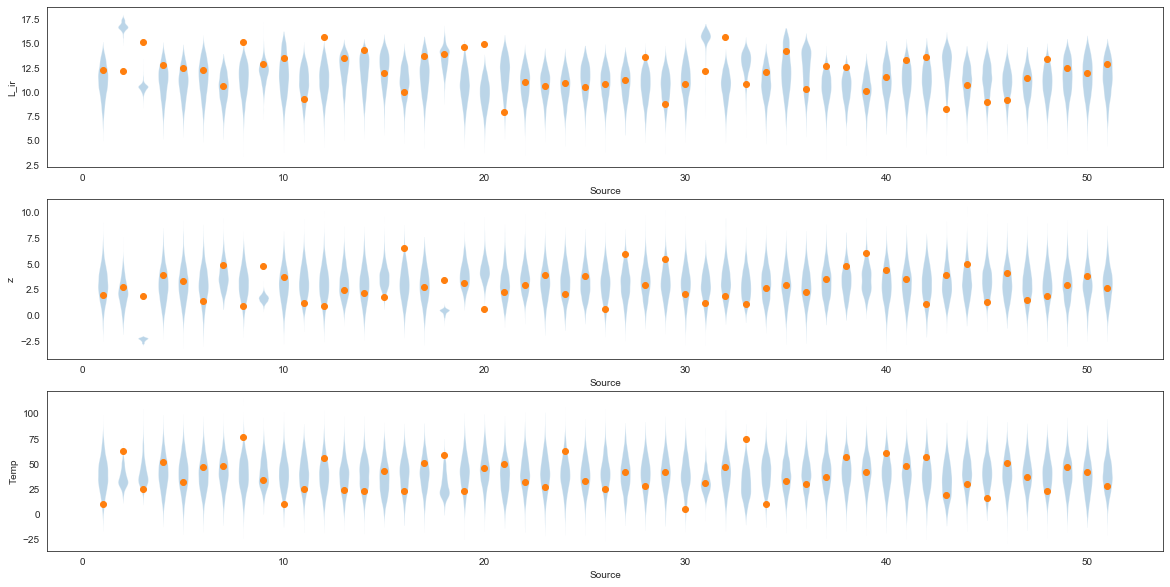

In [188]:
samp_index=9
phys_samp=inverse_transform_parameters(posteriors[samp_index].samples['params'])
phys_samp_prior_pred=inverse_transform_parameters(prior_pred['params'])
fig,axes=plt.subplots(3,1,figsize=(20,10))
names=[i.split('_mu')[0] for i in phys_prior.prior_table.colnames[0:3]]
for i in range(0,3):
    axes[i].violinplot(phys_samp[...,i].T,showextrema=False);
    axes[i].set_ylabel(names[i])
    axes[i].set_xlabel('Source')
    axes[i].plot(np.arange(1,priors_prior_pred_samp[0].nsrc+1),phys_samp_prior_pred[samp_index,:,i],'o')

Z score$$z=|(\mu_{post}-\theta_{true})/\sigma_{post}|$$

how accurately the posterior recovers ground truth and whether there is any bias. Close to zero indicate more accurate, less biased posteriors.

Posterior Shrinkage$$s=1-\sigma^2_{post}/\sigma^2_{prior}$$

quantifies how much the posterior learns from a given observation. Close to zero indicates dominated by prior, close to one indicates dominated by data.

Assuming that we are accurately recovering posteriors across all of the simulated observations then we can proceed to analyse the range of behaviors in these posteriors. For example, the posterior z-score of a given parameter,

$$z=|(\mu_{post}-\theta_{true})/\sigma_{post}|$$
quantifies how accurately the posterior recovers the ground truth and whether there is any bias. Values close to zero indicate more accurate, less biased posteriors.

At the same time the posterior shrinkage,

$$s=1-\sigma^2_{post}/\sigma^2_{prior}$$
quantifies how much the posterior learns from a given observation. Our visualisation of the posterior and prior for $\alpha$ and $\beta$ had already indicated that the inference had given us information on both parameters. Shrinkage allows us to quantify this. A value near zero indicates that the data provide little information beyond that encoded in the prior distribution while shrinkage near one indicates highly informative observations.

In [164]:
def zscore(posterior, truth):
    return np.abs((np.mean(posterior)-truth)/np.std(posterior))
def shrinkage(posterior,prior):
    return 1-(np.var(posterior)/np.var(prior))

phys_samp_prior_pred=inverse_transform_parameters(prior_pred['params'])
param_z_score=np.empty((len(posteriors),phys_samp_prior_pred.shape[1],phys_samp_prior_pred.shape[2]))
param_shrinkage=np.empty((len(posteriors),phys_samp_prior_pred.shape[1],phys_samp_prior_pred.shape[2]))
for i in range(0,len(posteriors)):
    phys_samp=inverse_transform_parameters(posteriors[i].samples['params'])
    for o in range(0,phys_samp_prior_pred.shape[1]):
        for p in range(0,3):
            param_z_score[i,o,p]=zscore(phys_samp[:,o,p],phys_samp_prior_pred[i,o,p])
            param_shrinkage[i,o,p]=shrinkage(phys_samp[:,o,p],phys_samp_prior_pred[:,o,p])

In [182]:
z_score_df=pd.DataFrame(param_z_score.reshape(-1,param_z_score.shape[-1]),columns=names)
z_score_df=z_score_df.melt(value_vars=names,var_name='param', value_name='zscore')


shrinkage_df=pd.DataFrame(param_shrinkage.reshape(-1,param_shrinkage.shape[-1]),columns=names)
shrinkage_df=shrinkage_df.melt(value_vars=names,var_name='param', value_name='shrinkage')

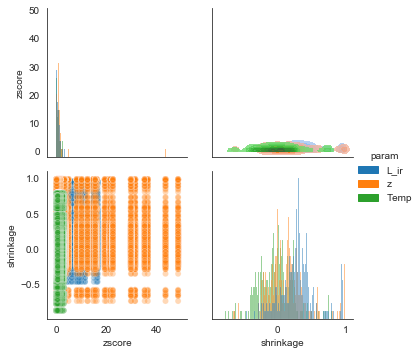

In [189]:
g=sns.PairGrid(pd.merge(z_score_df,shrinkage_df),hue="param")
g.map_diag(sns.histplot)
g.map_lower(sns.scatterplot,alpha=0.3)
g.map_upper(sns.kdeplot,alpha=0.8,n_levels=10,normed=True, shade=True,shade_lowest=False)
g.add_legend()



Temperature has a shrinkage of 0 on average which suggests it is dominated by the prior, as does redshift. This is not that suprising given we have only three wavelenghts and that temperature and redshift are degenerate. LIR does have more shrinkage, but not substantial. There are a few objects in which a reasoanble amont of shrinkage has occured. These are likley to be sources that have high fluxes and are therefore constrained. The majority of sources have low fluxes for which becuase of the noise in the maps (both instrumental and confusion) can only provide an upper limi. The distribution of z scores look fine.